In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [3]:
df.shape

(420451, 15)

In [4]:
temperature = df['T (degC)']
temperature = list(temperature)
len(temperature)

420451

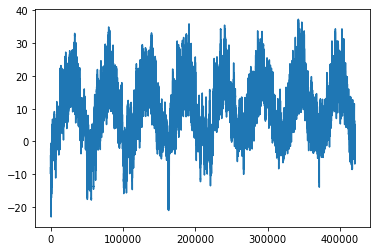

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

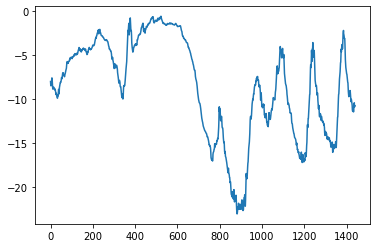

In [6]:
plt.plot(range(1440), temperature[:1440])

In [7]:
raw_data = df.iloc[:,1:]
raw_data.shape

(420451, 14)

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

In [11]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [19]:
sampling_rate = 6
sequence_length = 150
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [20]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 150, 14)
targets shape: (256,)


In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
818/818 [==============================] - 112s 135ms/step - loss: 26.1632 - mae: 3.7838 - val_loss: 9.5764 - val_mae: 2.3986
Epoch 2/50
818/818 [==============================] - 109s 134ms/step - loss: 14.6811 - mae: 2.9783 - val_loss: 9.2983 - val_mae: 2.3714
Epoch 3/50
818/818 [==============================] - 108s 132ms/step - loss: 13.6728 - mae: 2.8697 - val_loss: 9.2239 - val_mae: 2.3698
Epoch 4/50
818/818 [==============================] - 109s 133ms/step - loss: 13.1198 - mae: 2.8125 - val_loss: 9.3881 - val_mae: 2.3927
Epoch 5/50
818/818 [==============================] - 108s 131ms/step - loss: 12.6905 - mae: 2.7650 - val_loss: 9.4754 - val_mae: 2.3969
Epoch 6/50
818/818 [==============================] - 108s 132ms/step - loss: 12.3735 - mae: 2.7315 - val_loss: 9.7495 - val_mae: 2.4247
Epoch 7/50
818/818 [==============================] - 109s 133ms/step - loss: 12.0816 - mae: 2.6948 - val_loss: 9.4995 - val_mae: 2.3990
Epoch 8/50
818/818 [=====================

In [18]:
model = keras.models.lo ad_model("jena_lstm_dropout.keras ")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 13s 31ms/step - loss: 10.5963 - mae: 2.5645
Test MAE: 2.56


In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 187s 225ms/step - loss: 23.6054 - mae: 3.5999 - val_loss: 9.2939 - val_mae: 2.3641
Epoch 2/50
819/819 [==============================] - 161s 196ms/step - loss: 14.0242 - mae: 2.9022 - val_loss: 9.1211 - val_mae: 2.3513
Epoch 3/50
819/819 [==============================] - 161s 196ms/step - loss: 13.1946 - mae: 2.8171 - val_loss: 8.7616 - val_mae: 2.2910
Epoch 4/50
819/819 [==============================] - 161s 196ms/step - loss: 12.6431 - mae: 2.7543 - val_loss: 8.6521 - val_mae: 2.2761
Epoch 5/50
819/819 [==============================] - 161s 197ms/step - loss: 12.1716 - mae: 2.7051 - val_loss: 9.1060 - val_mae: 2.3415
Epoch 6/50
819/819 [==============================] - 162s 198ms/step - loss: 11.7228 - mae: 2.6572 - val_loss: 8.5427 - val_mae: 2.2599
Epoch 7/50
819/819 [==============================] - 166s 203ms/step - loss: 11.3647 - mae: 2.6192 - val_loss: 8.7890 - val_mae: 2.2964
Epoch 8/50
819/819 [=====================